This notebook aims to replicate the materials in the article [Selection Bias in Online Experimentation from Airbnb](https://medium.com/airbnb-engineering/selection-bias-in-online-experimentation-c3d67795cceb) (retrieved April 15, 2018). 

The article is not complicated, though it takes some time to get used to. Overall, the article is a nice introduction to the form of statistics that a Data Scientist is expected to understand at a Internet company. 

This article deals with statistical significance, hypothesis testing, and slightly about multiple comparison. 

# The context
The team at Airbnb performs a series of A/B test sequentially. Out of these tests, they select a subset of experiments that have statistically significant results (there are 6 of them). They are interested in finding the aggregate impact of these 6 experiments. There are 2 ways to estimate this:
- A bottom-up approach: based on the testing data (which has sequential experiments), they estimate the impact of each separate experiment
- An aggregate approach using a split / hold-out group: I assume that they combine these 6 experiments into one and perform another A/B testing. 

<img src="https://cdn-images-1.medium.com/max/1600/1*RHH0aobieNL3VA3LeMdJxA@2x.png" width="70%">

The result shows an apparent discrepancy between the impact: bottom-up approach has an estimate of 7.2% while split-holdout has an estimate of 4%. While there are many confounding factors at play such as the variance in the experiment results, seasonal effect in experiments, the authors from Airbnb use this example to show the Selection bias in this experiment setting.

# The bias
By selecting these 6 experiments out of all the experiments perform, we have incurred a selection bias: these experiments have been selected precisely because of their good results, even though it may be due to chance. Therefore, our value of 7.2% ( the sum of values from these 6 experiments) is an over-estimate of the aggregate impact of these __6 experiments__. 

Whether these 6 experiments should have been selected is another issue altogether.

# Mathematical explanation
Suppose we run $n$ experiments independently, the result of each follows a normal distribution N($ a_i$, 1%) with i = 1,2,..10. We then select only those that are statistically different from 0: $ A = \{ i \mid \frac{X_i}{\sigma_i} > t_i \}$ where $t_i$ is the critical value of individual experiment). If we use the same level of significance for all experiments, then all $t_i$ are the same, say the familiar 1.96 for 2.5% significance level for a one-sided test. We take the sum of these values to get an estimate of the aggregate effect:
$$S_A = \Sigma \{ i\in A\}X_i$$

We are interested in knowing whether whether this sum is actually a good estimation for the aggregate impact of these features or not, ie: $$T_A = \Sigma \{ i\in A\}a_i$$ wheren $a_i$ is the real, unobserved value.

Note that $A$ itself is a random variable and has its own distribution. Nevertheless, we can attempt to answer the question above by comparing $E_X[S_A]$ and $E_X[T_A]$. We can actually show that $E_X[S_A] \geq E_X[T_A]$ by showing $E_X[S_A-T_A]\geq0$.
Here I omit the subscript X for clarity:

$$E[S_A-T_A]=E[\sum_{i \in A}(X_i-a_i)] = E[\sum_{i=1}^n I(i\in A)\:(X_i-a_i)]$$
$$=\sum_{i=1}^n E[I(i\in A)\:(X_i-a_i)]=\sum_{i=1}^n E[I(\frac{X_i}{\sigma_i} > t_i)\:(X_i-a_i)]$$

We are making progress by breaking the sum into $n$ smaller chunks, ie: we can treat each experiment separately. I was intimidated by the indicator function $I(\frac{X_i}{\sigma_i} > t_i)$, but we can re-write this in a more intuitive form:
$$E[I(X_i> \sigma_i * t_i)\:(X_i-a_i)] = E[I(X_i-a_i> \sigma_i * t_i-a_i)\:(X_i-a_i)]$$

The explanation in the article is that each summand (above) is "the mean of lower truncated mean-zero distribution" and is positive, therefore the sum is positive, QED. Personally, I don't understand the jargon here so what I did was to re-write $X_i-a_i = Y_i$ and $sigma_i * t_i-a_i$ as $something$, then the summand becomes:
$$E[I(Y_i > something)\:Y_i]$$

Recall that $E[Y_i]=E[X_i]-a_i=0$, so $Y_i$ has mean-zero. Now the quote makes sense:
- If you take the average of $Y_i$ across all possible values, you get 0, ie: mean-zero distribution
- If you only care about all the values greater than a floor (in this case the value in $something$) (this is the "lower truncated"), then the average of these values is definitely greater than 0. 

Now that we have reduced the expression into this form, it appears simple enough that there should be a formula to calculate this explicitly. Indeed, in the article, the Airbnb team calculate this term as an adjustment to their estimates.
# Illustration using Python

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import invgamma, truncnorm

def Generate_Sample(n):
    sigma_2 = invgamma.rvs(a=3, scale =1, size = n)
    sigma = np.sqrt(sigma_2)
    z_i = np.random.normal(loc=0.2, scale=0.7, size = n)
    lower = -1.5
    upper = 2.0
    rvs = [0.0] * n
    for i in range(n):
        tmp1= (lower-z_i[i]) /sigma[i]
        tmp2 = (upper-z_i[i]) /sigma[i]
        rvs[i] = truncnorm(tmp1, tmp2, loc = z_i[i], scale = sigma[i]).rvs(1)[0]
    
    return np.array(rvs), z_i, sigma

N = 1000

rvs = [None] * N
z_i = [None] * N
sigma = [None] * N
for i in range(N):
    rvs[i], z_i[i], sigma[i]  = Generate_Sample(30) 

5.38629064372
3.84278124944
11.7567161192


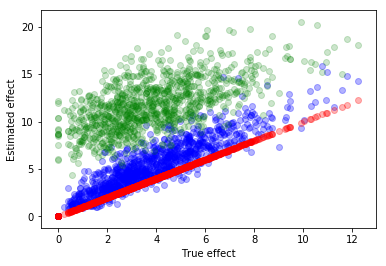

In [15]:
observed = [0.0] * N
real = [0.0] * N
true = [0.0] * N

for i in range(N):
    # t_stat is observed value divided by sigma
    # this implies that sigma already takes into account the sample size
    t_stat = rvs[i]/sigma[i]
    
    observed[i] = rvs[i][t_stat > 1.96].sum()
    real[i] = z_i[i][t_stat > 1.96].sum()
    true[i] = z_i[i][z_i[i] > 0].sum()
       
plt.scatter(real, observed, color = 'blue', alpha = 0.3)
plt.scatter(real, real, color = 'red', alpha = 0.3)
plt.scatter(real, true, color = 'green', alpha = 0.2)
plt.xlabel("True effect")
plt.ylabel("Estimated effect")

print(np.mean(observed))
print(np.mean(real))
print(np.mean(true))

The blue and red points are just the same in Airbnb's article. 
- The red points are the true effects: given that you observe some variables that are statistically significant (t-statistic > 1.96), you sum the true value of these variables
- The blue points are the observed effects: for the statistically significant variables above, you sum their observed values

The blue points are almost always above the red points, implying that we have a positive selection bias. This selection bias is calculated in the next section.

What about the green points? The green points are simply *true* value, without any need for statistical significance. These are the values that ideally we want to know. The true value is higher than both the red and blue points because the true value does not suffer from the 1-tail test, which omits many variables. For this particular setting, does this mean that we will under-estimate the true value most of the time?


# Airbnb's adjustment
Airbnb's approach is to use analytical formula to calculate the bias and then use that to adjust their estimates. Recall that the bias is:
$$E[S_A-T_A]=\sum_{i=1}^n E[I(\frac{X_i}{\sigma_i} > t_i)\:(X_i-a_i)]$$
and each summand has the form:
$$E[\:I(\frac{X_i}{\sigma_i} > t_i)\:(X_i-a_i)]=E[\:I(X_i-a_i> \sigma_i * t_i-a_i)\:(X_i-a_i)]$$

Because $X_i-a_i$ is a normal distribution with mean 0 and standard deviation $sigma_i$, we have a formula readily available (see (here, section 3.6)[https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf]). Though this formula is for the truncated normal distribution, which contains the conditional, we can start with this and see if we need to fix anything later.

For simplicity and consistency with the paper, let $\alpha = \frac{\sigma_i * t_i-a_i}{\sigma_i}$ and $\beta=\inf$, we have the bias
$$0-\sigma_i*\frac{0-\phi(0,1;\alpha)}{1-\Phi(0, 1;\alpha)} = \sigma_i*\frac{\phi(0,1;\alpha)}{1-\Phi(0, 1;\alpha)} = \frac{\sigma_i*\phi(\frac{\sigma_i*t_i-a_i}{\sigma_i})}{1-\Phi(0 ,1;\alpha)}$$

The formula in the paper is for the truncated normal, which contains a conditional term, hence the $1-\Phi(0 ,1;\alpha)$. In our problem, we can omit this term, leaving us: $$\sigma_i*\phi(\frac{\sigma_i*t_i-a_i}{\sigma_i})$$


# Extra materials
If you are interested in understanding more about these concepts, I suggest looking up for materials related to Multiple Comparison. I find this to be a comprehensive resource:
http://www.biostathandbook.com/multiplecomparisons.html

# My experiments
Based on the green points in the graph, I wonder what will happen if we selected variables that have values that are non-negative, instead of forcing them to be positive. The critical value is now -1.96 instead of 1.96. In terms of average, it seems that we are getting much closer to the real values.

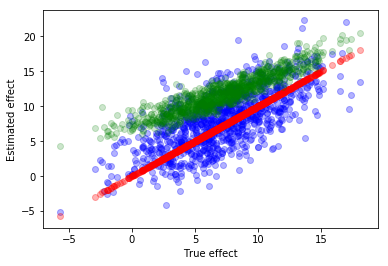

In [12]:
for i in range(N):
    t_stat = rvs[i]/sigma[i]    
    observed[i] = rvs[i][t_stat > -1.96].sum()
    real[i] = z_i[i][t_stat > -1.96].sum()
    true[i] = z_i[i][z_i[i] >= 0].sum()
plt.scatter(real, observed, color = 'blue', alpha = 0.3)
plt.scatter(real, real, color = 'red', alpha = 0.3)
plt.scatter(real, true, color = 'green', alpha = 0.2)
plt.xlabel("True effect")
plt.ylabel("Estimated effect")

In [14]:
print(np.mean(observed))
print(np.mean(real))
print(np.mean(true))

7.99441482424
7.11408892513
11.7567161192
